## Helper functions

In [17]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [18]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [19]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_eval(input_dict)

In [20]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [21]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [22]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [23]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [24]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [25]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [26]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_item_plot(scores_per_objective):  #later better axes
 
    data = scores_per_objective
    averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
    sorted_data = {k: v for k, v in sorted(averaged_data.items())}

    # Extract the keys (objectives) and values (averages) from the sorted dictionary
    keys = sorted_data.keys()
    values = sorted_data.values()

    # Create a bar plot
    plt.bar(keys, values)
    plt.xlabel('Objectives')
    plt.ylabel('Average')
    # plt.ylim(7,10)
    plt.title('Average per Objective')
    plt.xticks(rotation=45)
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [52]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [68]:
def t_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        t_stat, p_val = ttest_ind(dict_1[key], dict_2[key])
        print(f"For {key}, t-statistic is {t_stat:.2f} and the p-value is {p_val:.2f}")

In [86]:
from scipy.stats import mannwhitneyu

def u_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

## Data

In [2]:
from cot import Collection
med_qa = Collection(["med_qa"], verbose=False)

Loading med_qa...


In [7]:
# Determine sample size 
med_qa = med_qa.select(split="test", number_samples=1, random_samples=True, seed=0)

In [41]:
med_qa_cohere = Collection.from_json("./prelim_output/med_qa_zhou_cohere.json")
med_qa_turbo = Collection.from_json("./prelim_output/med_qa_zhou_eval_chatgpt.json")
med_qa_gpt_4 = Collection.from_json("./prelim_output/med_qa_zhou_eval_gpt4.json")

In [42]:
med_qa_gpt_4

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [30]:
#med_qa_cohere = med_qa = med_qa_cohere.select(split="test", number_samples=7, random_samples=True, seed=0)

In [104]:
from cot import Collection
med_qa_ts_100 = Collection.load_thoughtsource_100(names=['med_qa'],load_pregenerated_cots=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertpraas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/100 [00:00<?, ?ex/s]

In [120]:
from cot import Collection
med_qa = Collection(["med_qa"], verbose=False)
# Determine sample size 
med_qa = med_qa.select(split="test", number_samples=600, random_samples=True, seed=99)


Loading med_qa...


In [121]:
from numpy import loadtxt, savetxt
ts_100_ids = loadtxt("/Users/robertpraas/Desktop/ThoughtSource/notebooks/internal_documentation/paper_2/thoughtsource_100_ids.txt", dtype=str, comments="#", delimiter=",", unpack=False)
med_qa = med_qa.filter(lambda ex: ex['id'] not in ts_100_ids)
# then merge it




Loading cached processed dataset at /var/folders/wq/slcg80w1143270jpznm3k9hm0000gn/T/tmp4cu4rs55/cache-c12d68b3edf27cc8.arrow


In [127]:
med_qa = med_qa.select(split="test", number_samples=400, random_samples=True, seed=1998)

In [132]:
med_qa.dump("med_qa_400")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [129]:
med_qa_ts_100

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [130]:
test = med_qa.merge(med_qa_ts_100)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [131]:
test

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

## Generate extra data

In [ ]:
# generate cohere
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "cohere",
    "api_time_interval": 1,
    "engine": "command-xlarge-nightly", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

med_qa.dump("med_qa_zhou_cohere.json")
med_qa.evaluate()
med_qa.dump("med_qa_zhou_cohere.json")

In [9]:
# generate gpt-3.5-turbo
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
med_qa.dump("med_qa_zhou.json")
med_qa.evaluate()
med_qa.dump("med_qa_zhou_eval.json")

Generating med_qa...


In [ ]:
# generate gpt-4
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-4", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

med_qa.dump("med_qa_zhou_gpt4.json")
med_qa.evaluate()
med_qa.dump("med_qa_zhou_eval_gpt4.json")

med_qa.evaluate()

## Template

In [43]:
path = "./final_system_messages/first_template.yaml"

## Run Reflection

In [44]:
# gpt-3.5-turbo reflects on cohere 
data = med_qa_cohere
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "cohere"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")




Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [45]:
# 3.5 on 3.5
data = med_qa_turbo
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
# 4 on 3.5
#data = med_qa_turbo
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 3: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 13: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 17: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 31 May 2023 22:01:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7d0276e2396fc251-VIE', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time of 10 seconds.
(API-)Error in it

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
# 4 on 4 - if costs allow
data = med_qa_gpt_4
model = "gpt-4"
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-4"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 16: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 19: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 29: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 320e000bc87120f5ff50ae0fd64eec40 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 43: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 43: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 20 seconds.
(API-)Error in item 68: The server had an error while processing your request. Sorry about that!
Retrying with additi

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
## second template
path = "./final_system_messages/first_template.yaml"

In [49]:
# gpt-3.5-turbo reflects on cohere 
data = med_qa_cohere
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "cohere"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
# 3.5 on 3.5
data = med_qa_turbo
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 52: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
# 4 on 3.5
#data = med_qa_turbo
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 2: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6fdf52136ded5e058c274272f987da5a in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 2: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 20 seconds.
(API-)Error in item 5: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 5: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 20 seconds.
(API-)Error in item 14: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 14: The server had an error while processing your request. Sorry about that!
Retrying with additional

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## third template

In [84]:
# gpt-3.5-turbo reflects on cohere 
data = med_qa_cohere
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "third"
base_model = "cohere"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 13: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 11821c37defb8249cbc6380a23584c90 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 85: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID bfb19e08df1f5fcc4caf5fc23ee6898a in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [85]:
# 3.5 on 3.5
data = med_qa_turbo
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "third"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Evaluate Reflection

        Average
obj_1     59.00
obj_2     75.50
obj_3     59.10
obj_4     52.15
obj_5     55.70
obj_6     55.05
obj_7     52.05
obj_8     60.00
obj_9     36.60
obj_10    58.70
obj_11    63.50
scores true: 61.81818181818182
scores false: 54.779411764705884


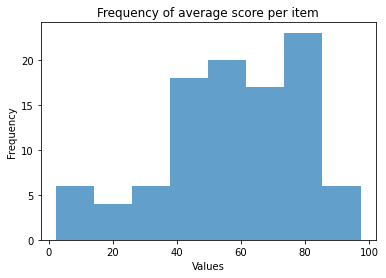

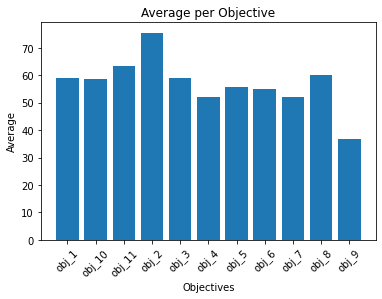

{'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_2': (25, 100), 'obj_9': (0, 80), 'obj_5': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_1': (0, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 22.24172755080965, 'obj_8': 25.34608929251695, 'obj_4': 23.871023387692382, 'obj_2': 18.16729217716567, 'obj_9': 25.848040779161803, 'obj_5': 19.18832768096062, 'obj_7': 21.20242743869034, 'obj_10': 21.551207517318968, 'obj_1': 23.148619523820116, 'obj_11': 35.230123703467406, 'obj_3': 27.278770374254627}
For obj_6, t-statistic is 1.24 and the p-value is 0.22
For obj_8, t-statistic is 1.97 and the p-value is 0.05
For obj_4, t-statistic is 1.59 and the p-value is 0.11
For obj_2, t-statistic is 0.81 and the p-value is 0.42
For obj_9, t-statistic is 1.24 and the p-value is 0.22
For obj_5, t-statistic is 0.75 and the p-value is 0.45
For obj_7, t-statistic is 1.16 and the p-value is 0.25
For obj_10, t-statistic is 1.42 and the p-value is 0.16
For obj_1, t-statistic is 1.41

In [71]:
data = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


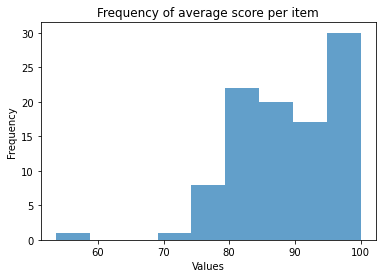

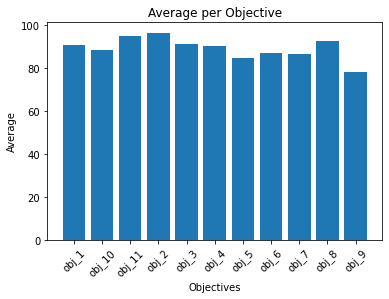

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [72]:
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


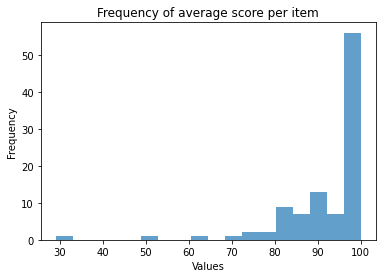

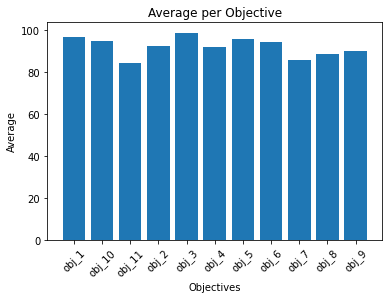

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [142]:
#note idx-2 
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     99.45
obj_2     98.30
obj_3    100.00
obj_4     98.20
obj_5     99.50
obj_6     98.30
obj_7     90.50
obj_8     97.95
obj_9     93.90
obj_10    99.15
obj_11    98.50
scores true: 97.96857463524131
scores false: 96.10047846889952


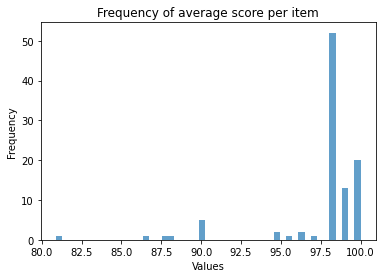

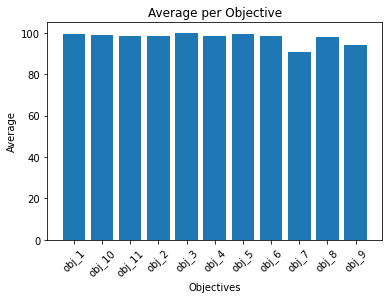

{'obj_6': (70, 100), 'obj_8': (70, 100), 'obj_4': (70, 100), 'obj_2': (70, 100), 'obj_9': (70, 100), 'obj_5': (90, 100), 'obj_7': (60, 100), 'obj_10': (80, 100), 'obj_1': (90, 100), 'obj_11': (50, 100), 'obj_3': (100, 100)}
{'obj_6': 5.135536717202729, 'obj_8': 5.90732296784801, 'obj_4': 5.389852043470677, 'obj_2': 5.135536717202729, 'obj_9': 5.84220105194208, 'obj_5': 2.190429135575903, 'obj_7': 7.571210756756962, 'obj_10': 3.557251804980975, 'obj_1': 2.2355032425551866, 'obj_11': 7.571210756756962, 'obj_3': 0.0}
For obj_6, t-statistic is 2.98 and the p-value is 0.00
For obj_8, t-statistic is 1.79 and the p-value is 0.08
For obj_4, t-statistic is 2.21 and the p-value is 0.03
For obj_2, t-statistic is 2.43 and the p-value is 0.02
For obj_9, t-statistic is 0.18 and the p-value is 0.86
For obj_5, t-statistic is 2.44 and the p-value is 0.02
For obj_7, t-statistic is 2.40 and the p-value is 0.02
For obj_10, t-statistic is 2.10 and the p-value is 0.04
For obj_1, t-statistic is 2.28 and the 

In [74]:
# Very low p-values - what is going on? Either mistake in code or a real difference?
data = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     59.00
obj_2     75.50
obj_3     59.10
obj_4     52.15
obj_5     55.70
obj_6     55.05
obj_7     52.05
obj_8     60.00
obj_9     36.60
obj_10    58.70
obj_11    63.50
scores true: 61.81818181818182
scores false: 54.779411764705884


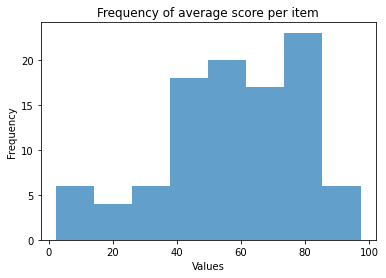

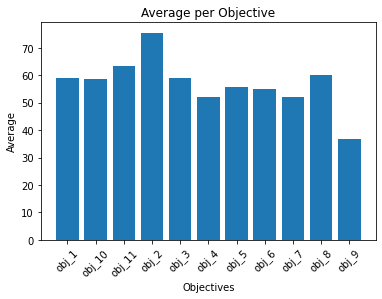

{'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_2': (25, 100), 'obj_9': (0, 80), 'obj_5': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_1': (0, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 22.24172755080965, 'obj_8': 25.34608929251695, 'obj_4': 23.871023387692382, 'obj_2': 18.16729217716567, 'obj_9': 25.848040779161803, 'obj_5': 19.18832768096062, 'obj_7': 21.20242743869034, 'obj_10': 21.551207517318968, 'obj_1': 23.148619523820116, 'obj_11': 35.230123703467406, 'obj_3': 27.278770374254627}
For obj_6, t-statistic is 1.24 and the p-value is 0.22
For obj_8, t-statistic is 1.97 and the p-value is 0.05
For obj_4, t-statistic is 1.59 and the p-value is 0.11
For obj_2, t-statistic is 0.81 and the p-value is 0.42
For obj_9, t-statistic is 1.24 and the p-value is 0.22
For obj_5, t-statistic is 0.75 and the p-value is 0.45
For obj_7, t-statistic is 1.16 and the p-value is 0.25
For obj_10, t-statistic is 1.42 and the p-value is 0.16
For obj_1, t-statistic is 1.41

In [78]:
data = Collection.from_json("./med_qa_second_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


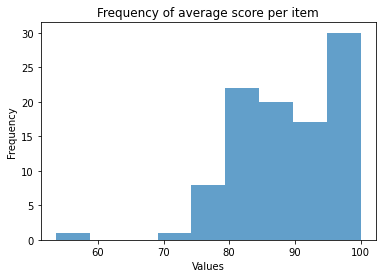

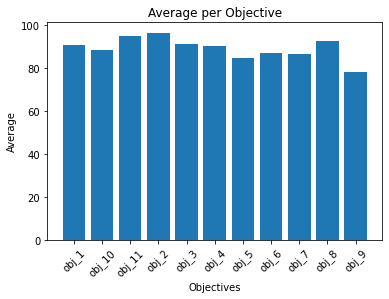

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [75]:
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


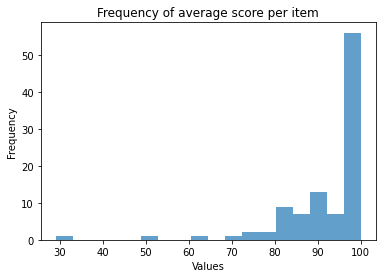

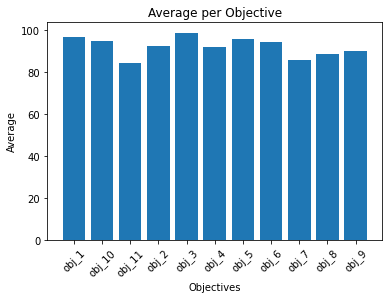

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [143]:
#note idx_cot
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      5.19
obj_2      6.48
obj_3      5.61
obj_4      4.29
obj_5      4.81
obj_6      5.08
obj_7      4.47
obj_8      5.46
obj_9      3.28
obj_10     5.04
obj_11     5.50
scores true: 5.3352272727272725
scores false: 4.870320855614973


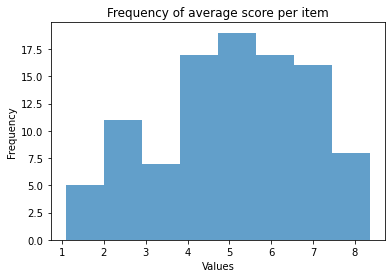

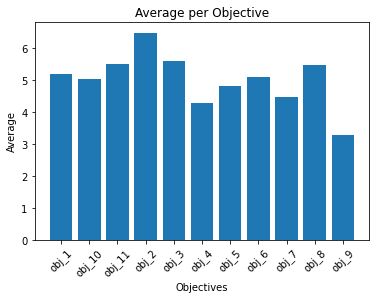

{'obj_6': (2, 8), 'obj_8': (1, 9), 'obj_4': (1, 9), 'obj_2': (2, 10), 'obj_9': (0, 7), 'obj_5': (1, 8), 'obj_7': (1, 8), 'obj_10': (1, 8), 'obj_1': (2, 8), 'obj_11': (0, 10), 'obj_3': (0, 9)}
{'obj_6': 1.6798268309019782, 'obj_8': 2.2175607675046374, 'obj_4': 1.881837700577054, 'obj_2': 2.1200343050397685, 'obj_9': 1.7001485377769348, 'obj_5': 1.4612503294276875, 'obj_7': 1.6603212540549697, 'obj_10': 1.8744426781140449, 'obj_1': 2.0631201240995747, 'obj_11': 2.886751345948129, 'obj_3': 2.1456792383623875}
For obj_6, t-statistic is 0.69 and the p-value is 0.49
For obj_8, t-statistic is 1.69 and the p-value is 0.09
For obj_4, t-statistic is 0.88 and the p-value is 0.38
For obj_2, t-statistic is 1.08 and the p-value is 0.28
For obj_9, t-statistic is 1.14 and the p-value is 0.26
For obj_5, t-statistic is 0.30 and the p-value is 0.76
For obj_7, t-statistic is 0.51 and the p-value is 0.61
For obj_10, t-statistic is 1.00 and the p-value is 0.32
For obj_1, t-statistic is 0.61 and the p-value 

In [139]:
data = Collection.from_json("./med_qa_third_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=5,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      8.11
obj_2      9.32
obj_3      8.44
obj_4      8.34
obj_5      7.47
obj_6      8.09
obj_7      7.90
obj_8      8.95
obj_9      7.06
obj_10     8.19
obj_11     9.09
scores true: 8.33228840125392
scores false: 8.181818181818182


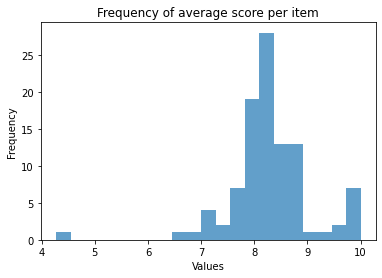

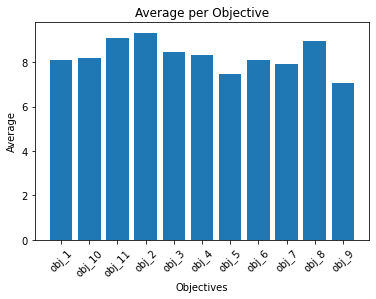

{'obj_6': (4, 10), 'obj_8': (5, 10), 'obj_4': (5, 10), 'obj_2': (6, 10), 'obj_9': (2, 10), 'obj_5': (4, 10), 'obj_7': (4, 10), 'obj_10': (3, 10), 'obj_1': (4, 10), 'obj_11': (5, 10), 'obj_3': (3, 10)}
{'obj_6': 0.888705789222721, 'obj_8': 0.7571210756756955, 'obj_4': 0.9235417115264979, 'obj_2': 0.6798692684790385, 'obj_9': 1.2294369245777328, 'obj_5': 1.0679443105822752, 'obj_7': 1.077782984471439, 'obj_10': 0.960797227895311, 'obj_1': 0.8027100562117262, 'obj_11': 0.9111542241585777, 'obj_3': 0.9777318630174611}
For obj_6, t-statistic is 1.32 and the p-value is 0.19
For obj_8, t-statistic is -0.03 and the p-value is 0.98
For obj_4, t-statistic is 0.72 and the p-value is 0.47
For obj_2, t-statistic is 1.33 and the p-value is 0.19
For obj_9, t-statistic is 0.41 and the p-value is 0.68
For obj_5, t-statistic is 0.71 and the p-value is 0.48
For obj_7, t-statistic is 1.47 and the p-value is 0.14
For obj_10, t-statistic is -0.00 and the p-value is 1.00
For obj_1, t-statistic is 0.41 and th

In [141]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=6,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [100]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=.4, power=0.9, alpha=0.05,ratio=0.67)
sample_size

164.84701057007064

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


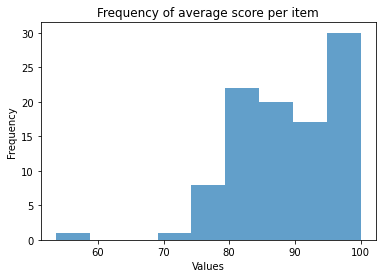

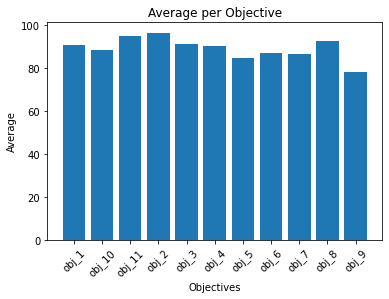

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [88]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [ ]:
# Average objective score
# Average item score (variance,span) - finding outliers?
# average objectives/item scores per true and false answers
# split range up for true, false?